In [2]:
import sys
import os
from tqdm import tqdm
import joblib

import pandas as pd
import numpy as np

import string
import re

import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from string import punctuation
import nltk
from nltk.stem.snowball import SnowballStemmer 
from nltk import word_tokenize
from nltk.stem import *
from nltk.corpus import stopwords
from pymystem3 import Mystem # by Yandex

`проверка, закачаны ли пунктуация со стоп-словами`

In [3]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
data = pd.read_csv("C:\projects\Python\ML\DataBases\lenta-ru-news.csv")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_14428\320065007.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("C:\projects\Python\ML\DataBases\lenta-ru-news.csv")


In [6]:
data.shape

(800975, 6)

In [7]:
data

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18
...,...,...,...,...,...,...
800970,https://lenta.ru/news/2019/12/14/shnur/,Шнуров раскритиковал Гагарину на «Голосе»,Певец Сергей Шнуров раскритиковал свою коллегу...,NaN,ТВ и радио,2019/12/14
800971,https://lenta.ru/news/2019/12/14/dolg/,В России предложили изменить правила взыскания...,Министерство юстиции России предложило изменит...,NaN,Все,2019/12/14
800972,https://lenta.ru/news/2019/12/14/dark_euro/,В России назвали «черную дату» для Европы,Испытание США ранее запрещенной Договором о ли...,NaN,Политика,2019/12/14
800973,https://lenta.ru/news/2019/12/14/meteo/,Россиянам пообещали аномально теплую погоду,В ближайшие дни в европейской части России пог...,NaN,Общество,2019/12/14


In [8]:
pd.DataFrame(data['topic'].value_counts()).T

topic,Россия,Мир,Экономика,Спорт,Культура,Бывший СССР,Наука и техника,Интернет и СМИ,Из жизни,Дом,...,Путешествия,69-я параллель,Крым,Культпросвет,Легпром,Библиотека,Оружие,ЧМ-2014,МедНовости,Сочи
count,160445,136621,79528,64413,53797,53402,53136,44663,27605,21734,...,6408,1268,666,340,114,65,3,2,1,1


## Обработка

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800975 entries, 0 to 800974
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     800975 non-null  object
 1   title   800975 non-null  object
 2   text    800970 non-null  object
 3   topic   738973 non-null  object
 4   tags    773756 non-null  object
 5   date    800975 non-null  object
dtypes: object(6)
memory usage: 36.7+ MB


In [10]:
data = data.dropna()

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712654 entries, 0 to 739175
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     712654 non-null  object
 1   title   712654 non-null  object
 2   text    712654 non-null  object
 3   topic   712654 non-null  object
 4   tags    712654 non-null  object
 5   date    712654 non-null  object
dtypes: object(6)
memory usage: 38.1+ MB


In [12]:
data

,url,title,text,topic,tags,date
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая,1914/09/16
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая,1914/09/16
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая,1914/09/17
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая,1914/09/17
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая,1914/09/18
...,...,...,...,...,...,...
739171,https://lenta.ru/news/2018/12/15/gasinparis/,«Желтые жилеты» прорвали кордон полиции под «М...,Протесты движения «желтых жилетов» в Париже сн...,Мир,Происшествия,2018/12/15
739172,https://lenta.ru/news/2018/12/15/su27/,Су-27 разбился на Украине,Истребитель Су-27 разбился в Житомирской облас...,Бывший СССР,Украина,2018/12/15
739173,https://lenta.ru/news/2018/12/15/spb/,В Петербурге нашли квартиру из 58 комнат,В Московском районе Санкт-Петербурга на продаж...,Дом,Квартира,2018/12/15
739174,https://lenta.ru/news/2018/12/15/gizin/,Падение горнолыжника на полной скорости попало...,Швейцарский горнолыжник Марк Гизин неудачно пр...,Спорт,Зимние виды,2018/12/15


In [13]:
pd.DataFrame(data['topic'].value_counts()).T

topic,Россия,Мир,Экономика,Спорт,Культура,Наука и техника,Бывший СССР,Интернет и СМИ,Из жизни,Дом,...,Путешествия,69-я параллель,Крым,Культпросвет,Легпром,Библиотека,Оружие,ЧМ-2014,МедНовости,Сочи
count,155004,136620,76423,57894,53530,53136,51370,44421,27513,21734,...,6370,1268,666,340,114,65,3,2,1,1


`удалим все темы, количество которых в датасете меньше 1000`

In [14]:
data = data.groupby('topic').filter(lambda x: len(x) >= 1000)

In [15]:
pd.DataFrame(data['topic'].value_counts()).T

topic,Россия,Мир,Экономика,Спорт,Культура,Наука и техника,Бывший СССР,Интернет и СМИ,Из жизни,Дом,Силовые структуры,Ценности,Бизнес,Путешествия,69-я параллель
count,155004,136620,76423,57894,53530,53136,51370,44421,27513,21734,11223,7581,7375,6370,1268


## Выборка данных

In [16]:
topics = ['Путешествия', 'Наука и техника', 'Экономика']
news_in_cat_count = 100  # обработка первых 100 текстов

In [17]:
df_res = pd.DataFrame()
for topic in tqdm(topics):
    df_topic = data[data['topic'] == topic][:news_in_cat_count]
    df_res = pd.concat([df_res, df_topic], ignore_index=True)

100%|██████████| 3/3 [00:00<00:00, 31.91it/s]


In [18]:
df_res['text']

0      Названы самые раздражающие фотографии, которые...
1      Австрийская авиакомпания FlyNiki открывает 10-...
2      Премьер-министр Греции Алексис Ципрас призвал ...
3      Китайский лоукостер Spring Airlines собрался п...
4      Большинство российских путешественников отметя...
                             ...                        
295    Входящие в тройку самых крупных испанских банк...
296    В Лондоне объявлено о возобновлении работы бир...
297    Внешнеторговый оборот России в январе - август...
298    Задолженность по заработной плате в Российской...
299    Международная аудиторская фирма Pricewaterhous...
Name: text, Length: 300, dtype: object

## Предобработка

In [19]:
def remove_punctuation(text):
    return "".join([ch if ch not in string.punctuation else ' ' for ch in text])

def remove_numbers(text):
    return ''.join([i if not i.isdigit() else ' ' for i in text])

def remove_multiple_spaces(text):
  """удаление специальных символов"""
  return re.sub(r'\s+', ' ', text, flags=re.I)

mystem = Mystem()  # стемминг от Яндекса

russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...'])
def lemmatize_text(text):
    tokens = mystem.lemmatize(text.lower())  # лемматизация - приведение всех слов к начальной форме
    tokens = [token for token in tokens if token not in russian_stopwords and token != " "]
    text = " ".join(tokens)
    return text

In [20]:
prep_text = [remove_multiple_spaces(remove_numbers(remove_punctuation(text.lower()))) for text in tqdm(df_res['text'])]

100%|██████████| 300/300 [00:00<00:00, 4540.58it/s]


In [ ]:
df_res['text_prep'] = prep_text

In [ ]:
df_res.head(1)

,url,title,text,topic,tags,date,text_prep
0,https://lenta.ru/news/2014/06/26/annoyingphotos/,Составлен рейтинг самых раздражающих отпускных...,"Названы самые раздражающие фотографии, которые...",Путешествия,Мнения,2014/06/26,названы самые раздражающие фотографии которые ...


## Стемминг

In [ ]:
stemmer = SnowballStemmer('russian')

In [ ]:
russian_stopwords = stopwords.words("russian")
russian_stopwords.extend(['…', '«', '»', '...', 'т.д.', 'т', 'д'])

In [ ]:
stemmed_texts_list = []
for text in tqdm(df_res['text_prep']):
    tokens = word_tokenize(text)    
    stemmed_tokens = [stemmer.stem(token) for token in tokens if token not in russian_stopwords]
    text = " ".join(stemmed_tokens)
    stemmed_texts_list.append(text)

df_res['text_stem'] = stemmed_texts_list

100%|██████████| 300/300 [00:00<00:00, 356.98it/s]


In [ ]:
def remove_stop_words(text):
    tokens = word_tokenize(text) 
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    return " ".join(tokens)

In [ ]:
sw_texts_list = []
for text in tqdm(df_res['text_prep']):
    tokens = word_tokenize(text)    
    tokens = [token for token in tokens if token not in russian_stopwords and token != ' ']
    text = " ".join(tokens)
    sw_texts_list.append(text)

100%|██████████| 300/300 [00:00<00:00, 2801.36it/s]


In [ ]:
df_res['text_sw'] = sw_texts_list

## Лемматизация

In [ ]:
lemm_texts_list = []
for text in tqdm(df_res['text_sw']):
    try:
        text_lem = mystem.lemmatize(text)
        tokens = [token for token in text_lem if token != ' ' and token not in russian_stopwords]
        text = " ".join(tokens)
        lemm_texts_list.append(text)
    except Exception as e:
        print(e)

100%|██████████| 300/300 [02:43<00:00,  1.83it/s]


In [ ]:
df_res['text_lemm'] = lemm_texts_list

In [ ]:
df_res.head(1)

,url,title,text,topic,tags,date,text_prep,text_stem,text_sw,text_lemm
0,https://lenta.ru/news/2014/06/26/annoyingphotos/,Составлен рейтинг самых раздражающих отпускных...,"Названы самые раздражающие фотографии, которые...",Путешествия,Мнения,2014/06/26,названы самые раздражающие фотографии которые ...,назва сам раздража фотограф котор уеха отпуск ...,названы самые раздражающие фотографии которые ...,называть самый раздражающий фотография который...


In [ ]:
def lemmatize_text(text):
    text_lem = mystem.lemmatize(text)
    tokens = [token for token in text_lem if token != ' ']
    return ' '.join(tokens)

In [ ]:
x = df_res['text_lemm']
y = df_res['topic']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [ ]:
my_tags = df_res['topic'].unique()
my_tags

array(['Путешествия', 'Наука и техника', 'Экономика'], dtype=object)

## Naive Bayes Classifier

In [ ]:
nb = Pipeline([('vect', CountVectorizer()),  # частота встречаемости слов
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])

In [ ]:
nb.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [ ]:
y_pred = nb.predict(x_test)

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))


accuracy 0.9333333333333333
                 precision    recall  f1-score   support

    Путешествия       0.89      0.89      0.89        18
Наука и техника       0.95      1.00      0.97        19
      Экономика       0.95      0.91      0.93        23

       accuracy                           0.93        60
      macro avg       0.93      0.93      0.93        60
   weighted avg       0.93      0.93      0.93        60



## SGDClassifier

In [ ]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])


In [ ]:
sgd.fit(x_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [ ]:
y_pred = sgd.predict(x_test)

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))


accuracy 0.9333333333333333
                 precision    recall  f1-score   support

    Путешествия       0.89      0.94      0.92        18
Наука и техника       1.00      0.95      0.97        19
      Экономика       0.91      0.91      0.91        23

       accuracy                           0.93        60
      macro avg       0.94      0.93      0.93        60
   weighted avg       0.94      0.93      0.93        60



## Logistic Regression

In [ ]:
logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1)),
               ])

In [ ]:
param_grid = {"clf__C": [0.001, 0.01, 0.1, 1, 10, 100]}

In [ ]:
logreg = GridSearchCV(logreg,
                           param_grid,
                           cv=5,
                           verbose=1)

In [ ]:
logreg.fit(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', LogisticRegression(n_jobs=1))]),
             param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100]}, verbose=1)

In [ ]:
y_pred = logreg.predict(x_test)

In [ ]:
print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred, target_names=my_tags))


accuracy 0.9333333333333333
                 precision    recall  f1-score   support

    Путешествия       0.89      0.94      0.92        18
Наука и техника       1.00      0.95      0.97        19
      Экономика       0.91      0.91      0.91        23

       accuracy                           0.93        60
      macro avg       0.94      0.93      0.93        60
   weighted avg       0.94      0.93      0.93        60



## Проверка работы модели

In [ ]:
test_text = '''
Доля рубля в расчетах за российский экспорт в феврале выросла до максимума с августа 2023 года — 41,6%, в импорте — до рекордных 38,1%, следует из данных Банка России.РИА Новости
"В феврале на фоне снижения объемов как экспорта, так и импорта доля юаня в экспортной выручке уменьшилась до 30,2% (в январе — 40,7%), а в расчетах за импорт — до 32,3% (в январе — 38,5%)", — пишет регулятор.РИА Новости
В стоимостном выражении экспортная выручка и расчеты за импорт в юанях составили 9,3 и 7,1 миллиарда долларов соответственно.РИА Новости
Как сообщал в конце февраля замминистра финансов Иван Чебесков, большинство стран БРИКС выступили за уход от доллара и переход на национальные валюты в торговле
'''

In [ ]:
test_text = ''.join([remove_multiple_spaces(remove_numbers(remove_punctuation(test_text.lower())))])

In [ ]:
tokens = word_tokenize(test_text)
tokens = [token for token in tokens if token not in russian_stopwords]
test_text = " ".join(tokens)

In [ ]:
test_text = lemmatize_text(test_text)

In [ ]:
pred = logreg.predict([test_text])
pred

array(['Экономика'], dtype=object)

## График встречаемости слов

In [ ]:
def frequency_words(doc):
    t = ' '.join([text for text in doc])
    tokens = word_tokenize(t)
    text = nltk.Text(tokens)
    fdist = nltk.probability.FreqDist(text)
    words = []
    freqs = []
    for word, freq in fdist.most_common(30):
        words.append(word)
        freqs.append(freq)
    plt.figure(figsize=(8, 6))
    plt.plot(words, freqs)
    plt.xticks(rotation=90)
    plt.xlabel('words')
    plt.ylabel('frequency')

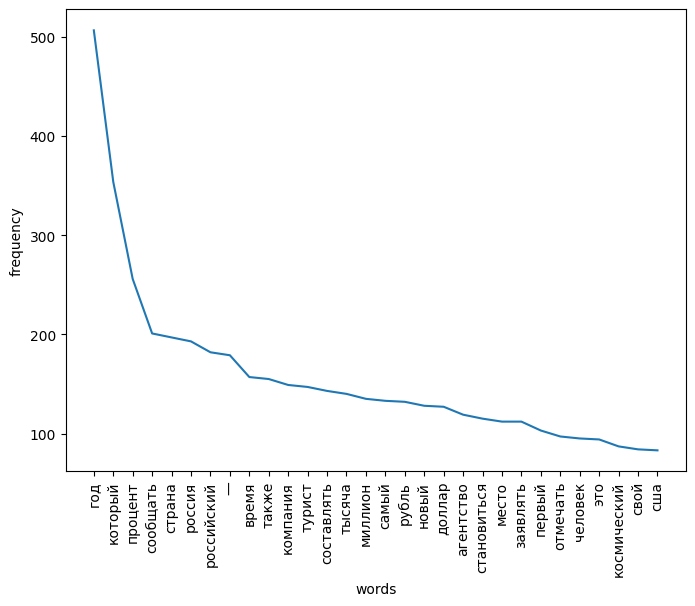

In [ ]:
frequency_words(df_res['text_lemm'])

## График tf-idf

In [ ]:
def plot_tf_idf(doc):
    # превращаем списки в одну строку + считаем частоту слов в документе
    t = ' '.join([text for text in doc])
    tokens = word_tokenize(t)
    type(tokens)
    text = nltk.Text(tokens)
    fdist = nltk.probability.FreqDist(text)

    # считаем всю длинну документа
    full_text_len = sum([len(text) for text in doc])

    # считаем tf
    tf_words = {}
    for key in fdist:
        tf_words[key] = fdist[key] / full_text_len

    full_doc_len = len(doc)  # количество текстов в документе

    # подсчитываем, в каком количестве документов встречается кадждое слово
    count_doc_with_words = {}
    for word in tf_words:
        count = 0
        for text in doc:
            if word in text:
                count += 1
        count_doc_with_words[word] = count

    # подсчитываем idf
    idf_words = {}
    for word in tf_words:
        idf_words[word] = np.log(full_doc_len/count_doc_with_words[word])
    
    # рисуем график
    for tf, idf in zip(tf_words, idf_words):
        plt.scatter(tf_words[tf], idf_words[idf])
        plt.text(tf_words[tf], idf_words[idf], tf)
    plt.xlabel('TF')
    plt.ylabel('IDF')
    plt.title('TF-IDF')

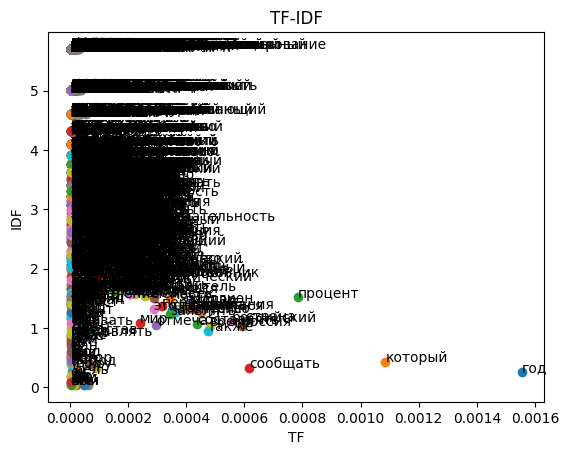

In [ ]:
plot_tf_idf(df_res['text_lemm'])